# Smash Bros

Today's extra nerdy dataset is stats from a tournament of the game *Super Smash Bros. Melee* for the Nintendo GameCube.  The stats were recorded during the tournament [Smash Summit 2017](https://liquipedia.net/smash/Smash_Summit/Spring_2017), these stats were collected by an older version the [Slippi](https://slippi.gg/faq) project.  The data was collected with this [R script](https://github.com/AdamSpannbauer/twitch_chat/blob/master/r_scripts/slippi_win.R) in 2017 (no promises the script still works).

The data contains a player id column, `gamerTag`, and a binary variable indicating if the player won the set, `won`; the rest of the variables are different statistics counted up throughout the set. 

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def show_top_missing(df, n=5, rate=True):
    """Utility to print most sparse columns by missing value"""
    if rate:
        missing_stats = df.isnull().mean()
    else:
        missing_stats = df.isnull().sum()
        
    top_missing = missing_stats.sort_values(ascending=False)
    print(top_missing.head(n))


data_url = 'https://raw.githubusercontent.com/AdamSpannbauer/twitch_chat/master/data/slippi_data/ssbm_win.csv'
ssbm = pd.read_csv(data_url)

In [9]:
from scipy.stats.mstats 

pandas.core.frame.DataFrame

In [2]:
show_top_missing(ssbm)
ssbm.head()

won                   0.0
openingsPerKill       0.0
numCombosStarted      0.0
totalComboDamage      0.0
averageComboDamage    0.0
dtype: float64


,gamerTag,numCombosStarted,totalComboDamage,averageComboDamage,maxComboDamage,percentTimeClosestCenter,percentTimeInShield,rollCount,numRecoveries,totalRecoveryDamage,...,numEdgeguards,numFailedEdgeguards,edgeguardSuccessPercent,numPunishesStarted,numKillingPunishes,totalPunishDamage,averagePunishDamage,neutralWinPercent,openingsPerKill,won
0,S2J,79,1119.17,14.166709,37.92,53.205737,7.801918,43,23,375.85,...,24,23,4.166667,66,9,1124.17,17.032879,45.833333,7.333333,0.0
1,Hungrybox,101,1724.49,17.074158,89.08,46.794263,3.151007,7,24,94.10,...,23,11,52.173913,78,15,1724.49,22.108846,54.166667,5.200000,1.0
2,Leffen,74,1226.34,16.572162,66.09,53.446289,3.783666,13,20,269.00,...,22,13,40.909091,50,11,1229.34,24.586800,53.763441,4.545455,1.0
3,PewPewU,60,912.56,15.209333,66.24,46.553711,1.933133,4,22,240.41,...,20,15,25.000000,43,6,913.56,21.245581,46.236559,7.166667,0.0
4,Infinite Numbers,53,932.94,17.602642,140.80,51.024071,8.328259,9,26,499.92,...,14,13,7.142857,45,5,932.94,20.732000,39.473684,9.000000,0.0


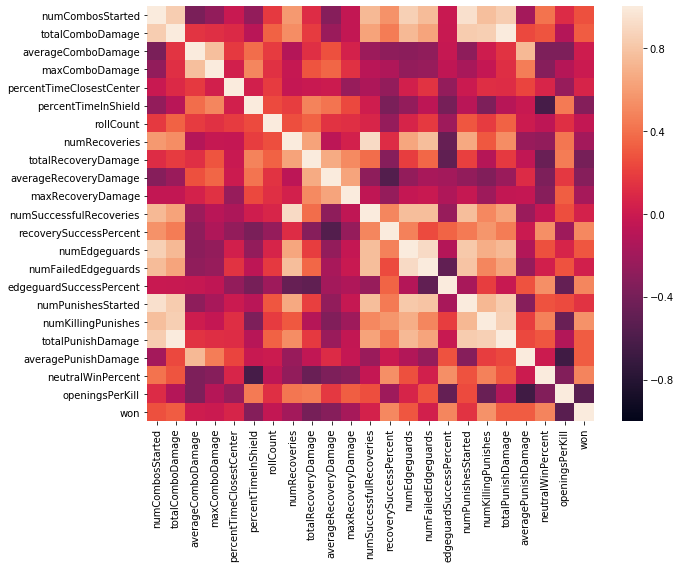

In [3]:
# How do our features correlate with each other?
plt.figure(figsize=(10, 8))
sns.heatmap(ssbm.corr(), vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

Our outcome variable that we want to predict is `won`, so we should pay extra attention to what's happening in its correlations.  Note, that `won` is a binary variable, so its correlations aren't really a great representation.  (remember, correlations are used for a pair of continuous variables, `won` is more of a categorical variable).

Nonetheless, if a feature sticks out with a high correlation (like `openingsPerKill`), we should take note of it.  We just shouldn't use this heatmap to rule any of the other features yet. 

In most machine learning contexts, we will isolate our input features from our target variable.  Player ID won't be much use since we want our model to predict wins for every player, not just the 16 players in our data set.  So we've dropped `gamerTag` & `won` and assigned it to `X`.  This `X` is a conventional way to specify that this variable is our input features; conversely, it is conventional to put your target for prediction into a variable named `y`.

In [4]:
X = ssbm.drop(columns=['won', 'gamerTag'])
y = ssbm['won']

Let's go ahead and try to build our first model to predict this win.  Since the topic at hand is feature selection, we won't really discuss the model being used; we'll just use it as a way to grade our features.  Note, this model building is also not following the best practice of doing a train/test split to evaluate accuracy.

In [5]:
model = LogisticRegression()
model.fit(X, y)
# In practice score on a test set
model.score(X, y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9285714285714286

We see we ran into a `ConvergenceWarning`, this is a potential problem with having too many features.  Despite this issue we ended up predicting with ~95% accuracy.

*Note, again, this is a **bad way to evaluate a model**, we should be testing our model on data the model has never seen before.*

## Feature Selection

We might be able to avoid this warning by narrowing down our features.  Narrowing down features has a lot of benefits, including:
* Aiding in computation issues (RE:above warning)
* Aiding in accuracy
    * Can be a direct result from helping first point
* Aiding in interpretability
    * A lot of times you're not only interested in predicting something accurately, but also explaining why you're good at making these predictions.  For example, in a business context you might want to accurately predict customer churn, but you're management would also really like to know what is indicating that a customer is going to churn.  With an easily interpretable model you can easily show the impact each input feature has on a customer's likelihood to churn.  With a lot of predictors this gets harder to parse out.
    * There's also an issue known as [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity).  This intuitively means that some of your input features are encoding the same information (like having a feature for `temperature_celsius` & one for `temperature_farenheit`).  When your model has multiple variables representing the same thing it can confuse the model, the model might still be accurate, but it will have more trouble explaining to you why it's accurate.
    
In this case, a way we can smartly select a subset of predictors is with `SelectKBest` with the `f_classif` method.  If you remember, ANOVA outputs a value called $F$, this is what the `f` in `f_classif` represents.  All we're doing here is running an ANOVA for each of our variables and target.

Our target variable is a category and all our predictors are numeric, so for each numeric feature we run an ANOVA using the target as the groups.  Below is an example using the feature `numKillingPunishes`.  To start we might visualize the differences between the 2 groups.  We see some difference, but we can quantify this difference using the `stats.f_oneway` function we've used before to perform an ANOVA.  We end up with an $F$ value of about `23.8`.

Note, we didn't really check for normality here.  ANOVA is fairly robust against violations of the normality assumption, in the case of ANOVA for variable selection, people play pretty fast and loose with normality.

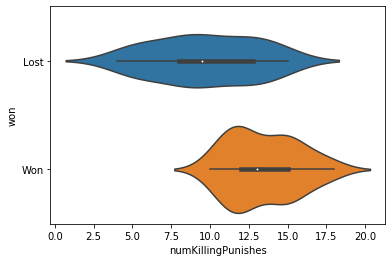

F_onewayResult(statistic=23.801775848225727, pvalue=9.83326076430818e-06)

In [6]:
won_text = ssbm['won'].replace({0: 'Lost', 1: 'Won'})
sns.violinplot(ssbm['numKillingPunishes'], won_text)
plt.show()

won = ssbm.loc[ssbm['won'] == 1, 'numKillingPunishes']
lost = ssbm.loc[ssbm['won'] == 0, 'numKillingPunishes']

stats.f_oneway(won, lost)

So we've done an ANOVA for one of our variables, we can use `SelectKBest` from `sklearn` to do the rest.  It will run the same ANOVA, store all the values of $F$, and then keep only the features with the top $k$ values of $F$.  We have to select the value of $k$, and there's not a general rule of thumb on what it should be. Below, I chose 5 cause ¯\\_(ツ)_/¯.

From the output, we can see the scores for each ANOVA that was run with `f_classif`, and we can confirm that we see the same value for `numKillingPunishes` as we did in our one variable example.

In [7]:
selector = SelectKBest(f_classif, k=5)

# Subset down to the best features auto-selected for prediction
k_best = selector.fit_transform(X, y)

# We can see/rank which features were the best
score_df = pd.DataFrame({'feature': X.columns,
                         'f_score': selector.scores_})
score_df = score_df.sort_values('f_score', ascending=False)
print(score_df.head())

# We can put back into a dataframe to see column names 
col_names = X.columns[selector.get_support()]
pd.DataFrame(k_best, columns=col_names).head()

                    feature    f_score
17       numKillingPunishes  23.801776
21          openingsPerKill  21.768686
12   recoverySuccessPercent  18.121388
15  edgeguardSuccessPercent  17.857051
20        neutralWinPercent  17.063896


,recoverySuccessPercent,edgeguardSuccessPercent,numKillingPunishes,neutralWinPercent,openingsPerKill
0,47.826087,4.166667,9.0,45.833333,7.333333
1,95.833333,52.173913,15.0,54.166667,5.200000
2,75.000000,40.909091,11.0,53.763441,4.545455
3,59.090909,25.000000,6.0,46.236559,7.166667
4,53.846154,7.142857,5.0,39.473684,9.000000


We could now move back to modeling this data using the same code as before, but now providing only the 5 'best' features.

In [10]:
model = LogisticRegression()
model.fit(k_best, y)
# In practice score on a test set
model.score(k_best, y)

0.8928571428571429

With this restricted set, we didn't get a `ConvergenceWarning`. We do see a drop in accuracy, but this might actually be a sign that our first model was [*overfitting*](https://en.wikipedia.org/wiki/Overfitting).  Again, we can't take much from the score on our training data (see note below, and above, and everywhere).

However, we didn't lose too much accuracy despite deleting 19 of our input columns.  This shows that we likely have a lot of 'dead weight' in our features, and we can likely predict the outcome without having all 24 features to wade through (which can be a burden for both our model and us during interpretation).

*Note, again, this is a **bad way to evaluate a model**, we should be testing our model on data the model has never seen before.*

## PCA

In PCA (principle components anaylsis) we capture all the variance of our data into 'components'.  What does that mean? Well, we'll be predicting our outcome based on how the other variables' values change (or vary).  So our model is really wanting to pick up on how the input features vary in relation to the outcome we're predicting.  PCA captures all this 'varying' in our data by combining our features, and it can capture this variance with less features than we started with.

Since we're really focused on how our features are varying, we `scale` them before doing PCA. Remember that `scale` will transform our inputs so that their means are 0 and their standard deviations are 1.  With all these standard deviations set to 1, none of the features will overpower the others in terms of their variance.  For example, the `totalComboDamage` has a variance of 188387.3 and `openingsPerKill` has a variance of 2.8, this is a big gap.  PCA is trying to maximize the amount of variation captured, and an easy way to shortcut this would be to focus in on features with larger variances; we want to put all our features on equal ground, and so we scale.

Below we see the effects of scaling on our features.

In [13]:
scaled_X = scale(X)

print('Feature variances before scaling:')
print(X.var())
print('\nFeature variances after scaling:')
print(pd.DataFrame(scaled_X, columns=X.columns).var())

Feature variances before scaling:
numCombosStarted              1066.254221
totalComboDamage            188387.321222
averageComboDamage               6.851588
maxComboDamage                 962.982273
percentTimeClosestCenter        31.313400
percentTimeInShield              7.621656
rollCount                      246.607792
numRecoveries                   73.836039
totalRecoveryDamage          20801.620480
averageRecoveryDamage           28.535200
maxRecoveryDamage              411.815102
numSuccessfulRecoveries         55.378896
recoverySuccessPercent         224.839493
numEdgeguards                   73.836039
numFailedEdgeguards             55.378896
edgeguardSuccessPercent        224.839493
numPunishesStarted             528.493182
numKillingPunishes              11.269805
totalPunishDamage           188083.438028
averagePunishDamage             12.956679
neutralWinPercent               23.728691
openingsPerKill                  2.754856
dtype: float64

Feature variances after sc

Now we can move onto performing PCA.  To do this we can use `sklearn.decomposition.PCA`, and the main thing left for us to decide is how many components.  The reading focuses in on eigenvalues, here we'll use the variance explained and a scree plot.  I'd say the 'elbow' that we typically look for in a scree plot occurs after our 4th component.  So we might choose to set `n_components` to 4.

Another item that you internalize about PCA is that all the outputted components are *orthogonal* to one another.  Aka they don't correlate at all.  We can prove this out using a heatmap.

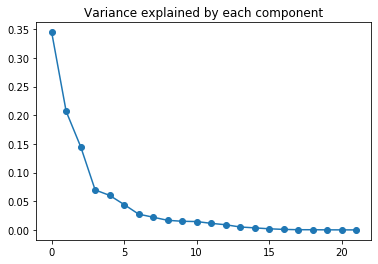

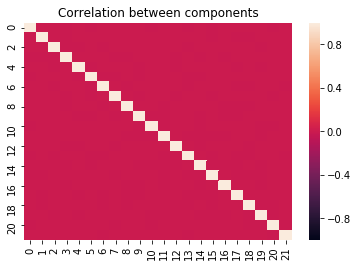

In [20]:
pca = PCA()
pca_X = pca.fit_transform(scaled_X)

plt.plot(pca.explained_variance_ratio_, marker='o')
plt.title('Variance explained by each component')
plt.show()

sns.heatmap(pd.DataFrame(pca_X).corr(), vmin=-1, vmax=1)
plt.title('Correlation between components')
plt.show()

In [26]:
pca = PCA(n_components=4)
pca_X = pca.fit_transform(scaled_X)

In [29]:
model = LogisticRegression()
model.fit(pca_X, y)
# In practice score on a test set
model.score(pca_X, y)

0.9107142857142857

So we went ahead and refit the model using our first 4 principle components.  We don't get a warning about convergence, and we seem to have a pretty decent fit (as judged by our bad scoring practice).  One thing to note about the model that was built.  It's going to be very hard to interpret.  We'll be able to see what effect each principle component has on the target variable.  This isn't the most intuitive thing to grasp, and it's even harder to explain to someone with a non-technical background.  PCA can sometimes be a positive in terms of model accuracy, but can also be a negative in terms of loss of iterpretability and understanding.

*Note, again, again, this is a **bad way to evaluate a model**, we should be testing our model on data the model has never seen before.*

In [30]:
import matplotlib
matplotlib.__version__

'3.1.2'